In [50]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt

In [51]:
data = pd.read_csv('./PRODUCTS.data', sep=',')
data.head()

,word,AspectCategory
0,flexible,functionality
1,use,functionality
2,powerful,performance
3,works,quality
4,fast,performance


In [52]:

nltk.download('punkt')
data['tokens'] = data['word'].apply(word_tokenize)
data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,word,AspectCategory,tokens
0,flexible,functionality,[flexible]
1,use,functionality,[use]
2,powerful,performance,[powerful]
3,works,quality,[works]
4,fast,performance,[fast]


In [53]:
#  Loads pre-trained GloVe word embeddings from the file 
glove_model = KeyedVectors.load_word2vec_format('./glove.6B.50d.txt', binary=False)

# embedding function
def get_embedding(token):
    try:
        return glove_model[token]
    except KeyError:
        return [0.0] * 50
    
data['embeddings'] = data['tokens'].apply(lambda tokens: [get_embedding(token) for token in tokens])
data.head()

,word,AspectCategory,tokens,embeddings
0,flexible,functionality,[flexible],"[[0.23288, -0.30383, 0.0058964, -0.75339, -0.0..."
1,use,functionality,[use],"[[0.36404, -0.16619, 0.28584, -0.17042, -0.422..."
2,powerful,performance,[powerful],"[[0.64857, -0.77899, 0.64121, 0.22266, 0.82489..."
3,works,quality,[works],"[[0.56266, 0.59051, -0.72821, -0.65968, 0.0804..."
4,fast,performance,[fast],"[[-0.20784, -0.80485, 0.10014, -0.28913, -0.02..."


In [54]:
# Pad embeddings
maxlen = 50
data["padded_embeddings"] = data["embeddings"].apply(
    lambda x: pad_sequences(x, maxlen=maxlen, dtype="float32", padding="post")[0]
)

data.head()

,word,AspectCategory,tokens,embeddings,padded_embeddings
0,flexible,functionality,[flexible],"[[0.23288, -0.30383, 0.0058964, -0.75339, -0.0...","[0.23288, -0.30383, 0.0058964, -0.75339, -0.00..."
1,use,functionality,[use],"[[0.36404, -0.16619, 0.28584, -0.17042, -0.422...","[0.36404, -0.16619, 0.28584, -0.17042, -0.4225..."
2,powerful,performance,[powerful],"[[0.64857, -0.77899, 0.64121, 0.22266, 0.82489...","[0.64857, -0.77899, 0.64121, 0.22266, 0.82489,..."
3,works,quality,[works],"[[0.56266, 0.59051, -0.72821, -0.65968, 0.0804...","[0.56266, 0.59051, -0.72821, -0.65968, 0.0804,..."
4,fast,performance,[fast],"[[-0.20784, -0.80485, 0.10014, -0.28913, -0.02...","[-0.20784, -0.80485, 0.10014, -0.28913, -0.026..."


In [55]:
# data = data.drop_duplicates(subset=['word', 'AspectCategory'])
# data.shape

In [56]:
# Prepare X and Y
X = np.array(data['padded_embeddings'].tolist())
y = data['AspectCategory'].values
aspect_labels = data['AspectCategory'].unique().tolist()
# One-hot encode Y where each category is represented as a binary vector
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))
y[0]

C:\Users\abdes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([0., 1., 0., 0., 0., 0., 0.])

In [57]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [58]:
# Convert indices to integers and check for negative values
def preprocess_indices(X):
    X_int = np.rint(X).astype(int)
    X_int[X_int < 0] = 0
    return X_int


X_train = preprocess_indices(X_train)
X_val = preprocess_indices(X_val)
X_test = preprocess_indices(X_test)

unique_words = data["word"].unique()
vocabulary_size = len(unique_words)
# print(unique_words)


def check_indices(X, vocab_size):
    return (X < 0).any(), (X >= vocab_size).any()


# Re-run the check
print("X_train:", check_indices(X_train, vocabulary_size))
print("X_val:", check_indices(X_val, vocabulary_size))
print("X_test:", check_indices(X_test, vocabulary_size))
print("Max index in X_train:", X_train.max())

X_train: (False, False)
X_val: (False, False)
X_test: (False, False)
Max index in X_train: 4


In [59]:

# Hyperparameter
# filters are used to extract features from the input data
filters_values = [64, 128, 256]
# kernel size determines the size of the filter
kernel_sizes_values = [3, 5, 7]
# number of the neurons in specific layer
layer_sizes_values = [32, 64, 128]

best_accuracy = 0
best_hyperparameters = {}

In [60]:

for filters in filters_values:
    for kernel_size in kernel_sizes_values:
        for layer_size in layer_sizes_values:
            # Build model with current hyperparameters
            model = Sequential()
            # Adds an Embedding layer to the model
            model.add(Embedding(input_dim=vocabulary_size, output_dim=50, input_length=maxlen))
            # Adds a 1D convolutional layer to the model
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Flatten())
            model.add(Dense(layer_size, activation='relu'))
            # Dropout helps prevent overfitting by randomly dropping out a fraction of neurons during training
            model.add(Dropout(0.5))
            model.add(Dense(y.shape[1], activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Train model
            history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=0)

            # Evaluate model on validation set
            _, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

            # Update best hyperparameters if the current configuration is better
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = {'filters': filters, 'kernel_size': kernel_size, 'layer_size': layer_size}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)

Best Hyperparameters: {'filters': 64, 'kernel_size': 7, 'layer_size': 128}
Best Validation Accuracy: 0.7818182110786438


In [61]:
# Visualize training history for the best model
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

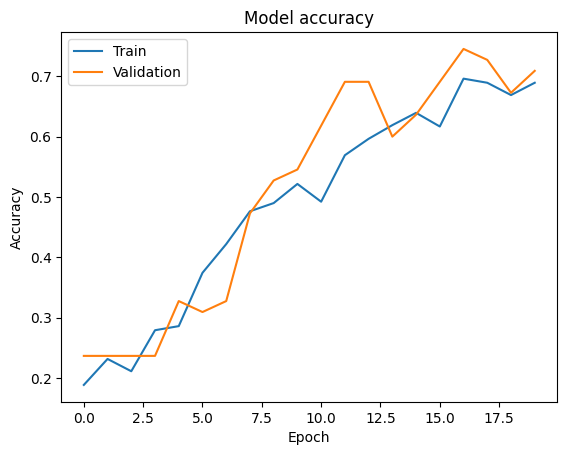

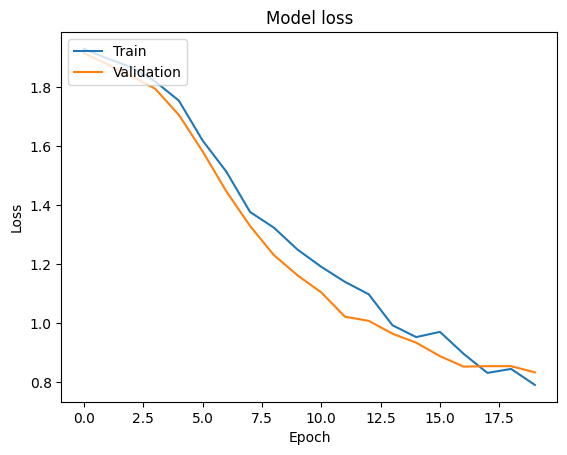

In [62]:

# Visualize training history for the best model
plot_history(best_history)

In [63]:
# Build the best model using the discovered hyperparameters
best_model = Sequential()
best_model.add(Embedding(input_dim=vocabulary_size, output_dim=50, input_length=maxlen))
best_model.add(Conv1D(filters=best_hyperparameters['filters'], kernel_size=best_hyperparameters['kernel_size'], activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))
best_model.add(Conv1D(filters=best_hyperparameters['filters'], kernel_size=best_hyperparameters['kernel_size'], activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))
best_model.add(Flatten())
best_model.add(Dense(best_hyperparameters['layer_size'], activation='relu'))
best_model.add(Dropout(0.5))
best_model.add(Dense(y.shape[1], activation='softmax'))
best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
# Train the best model
best_history = best_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
7/7 [==============================] - 1s 35ms/step - loss: 1.9218 - accuracy: 0.1837 - val_loss: 1.8865 - val_accuracy: 0.2364
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 1.8738 - accuracy: 0.2132 - val_loss: 1.8331 - val_accuracy: 0.2364
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 1.8270 - accuracy: 0.2381 - val_loss: 1.7745 - val_accuracy: 0.2727
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 1.7447 - accuracy: 0.3016 - val_loss: 1.6849 - val_accuracy: 0.2727
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 1.5818 - accuracy: 0.4218 - val_loss: 1.5854 - val_accuracy: 0.3273
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 1.4202 - accuracy: 0.4785 - val_loss: 1.4268 - val_accuracy: 0.4545
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 1.2960 - accuracy: 0.5102 - val_loss: 1.3587 - val_accuracy: 0.4545
Epoch 8/20
7/7 [============

In [65]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

2/2 [==============================] - 0s 6ms/step - loss: 0.6063 - accuracy: 0.8214
Test Loss: 0.6063, Test Accuracy: 0.8214


In [68]:

import numpy as np

# Your existing code for preparing input data
word = ["durable"]
dict = {'word': word}
df = pd.DataFrame(dict)
df['tokens'] = df['word'].apply(word_tokenize)
df['embeddings'] = df['tokens'].apply(lambda tokens: [get_embedding(token) for token in tokens])
df['padded_embeddings'] = df['embeddings'].apply(lambda x: pad_sequences(x, maxlen=maxlen, dtype='float32', padding='post')[0])
input_data = np.array(df['padded_embeddings'].tolist())
input_data = preprocess_indices(input_data)


predictions = best_model.predict(input_data)

# print(predictions)
# to decode the one-hot encoded prediction back to its original format
decoded_predictions = encoder.inverse_transform(predictions)

# reshape it back to its original shape
decoded_predictions = decoded_predictions.reshape(-1)

# Interpret the predictions
predicted_class_index = np.argmax(predictions)
confidence = predictions[0, predicted_class_index]


# Print the results
print("Predicted Class Index:", predicted_class_index)
print("Predicted Aspect Label:", decoded_predictions[0])
print("Predicted Class Confidence:", confidence)


1/1 [==============================] - 0s 92ms/step
Predicted Class Index: 4
Predicted Aspect Label: quality
Predicted Class Confidence: 0.90697294
